In [2]:
from warnings import filterwarnings
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords #Common English words (like "the", "is", "and") that are often removed in NLP.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textblob import Word,TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')

In [3]:
#Load the Data
df = pd.read_csv(r"C:\Users\Python Class\AI_Echo_Project5\chatgpt_reviews - chatgpt_reviews.csv")
df.head(1)

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2/15/2025,Impressive,Mother former community upon vote fact. Sure s...,2,ybass,68,78,Mobile,es,Canada,3.0,No


In [4]:
# Missing values
df.isnull().sum()

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64

# Data Preprocessing

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from textblob import Word

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Drop missing values
df = df.dropna(subset=['review']).reset_index(drop=True)

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation & special characters
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)
    # 4. Tokenize
    tokens = text.split()
    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # 6. Lemmatization
    tokens = [Word(word).lemmatize() for word in tokens]
    # 7. Join back into string
    return " ".join(tokens)

# Apply cleaning
df["cleaned_text"] = df["review"].astype(str).apply(clean_text)

# Remove rare words (appearing less than 3 times across corpus)
word_freq = pd.Series(" ".join(df["cleaned_text"]).split()).value_counts()
rare_words = set(word_freq[word_freq < 3].index)

df["cleaned_text"] = df["cleaned_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in rare_words])
)

# ✅ Final check
print(df[["review", "cleaned_text"]].head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nithu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nithu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nithu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                              review  \
0  Mother former community upon vote fact. Sure s...   
1  General paper understand main. Or age half won...   
2  Here situation his high stage. Agree certainly...   
3  Rule court behind growth reality. Tonight whos...   
4  Case opportunity season road write. Effort gre...   
5  Top position able wear its between kid. Number...   
6  Brother individual process always. Sing behind...   
7  Upon bit pick. Seven along unit local these. C...   
8  Number choice student production son understan...   
9  Stand space approach southern.\nGlass federal ...   

                                        cleaned_text  
0  mother former community upon vote fact sure st...  
1  general paper understand main age half wonder ...  
2  situation high stage agree certainly blue thou...  
3  rule court behind growth reality tonight whose...  
4  case opportunity season road write effort gree...  
5  top position able wear kid number author minut... 

In [47]:
# Saving the file
# Ensure sentiment column exists
df['feedback_sentiment'] = df['feedback_sentiment'].fillna('Neutral')

# Keep only relevant columns for dashboard

df_cleaned = df[['date', 'title', 'review', 'cleaned_text', 'username', 'rating', 'feedback_sentiment', 'version', 'verified_purchase',
                 'platform', 'location', 'language', 'review_length', 'helpful_votes']]

# Save CSV
df_cleaned.to_csv(r"C:\Users\Python Class\AI_Echo_Project5\cleaned_reviews.csv", index=False)
print("successfully saved")


successfully saved


## EDA - Exploratory Data Analysis

# Sentiment Distribution

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon') #Downloads the dictionary of words with their sentiment scores (positive/negative/neutral).

sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sid.polarity_scores(str(text))
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['feedback_sentiment'] = df['review'].apply(vader_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nithu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
#Distinct values of review and its counts
print(f"Feedback value count: \n{df['feedback_sentiment'].value_counts()}")

Feedback value count: 
feedback_sentiment
Positive    7065
Negative    1949
Neutral      986
Name: count, dtype: int64


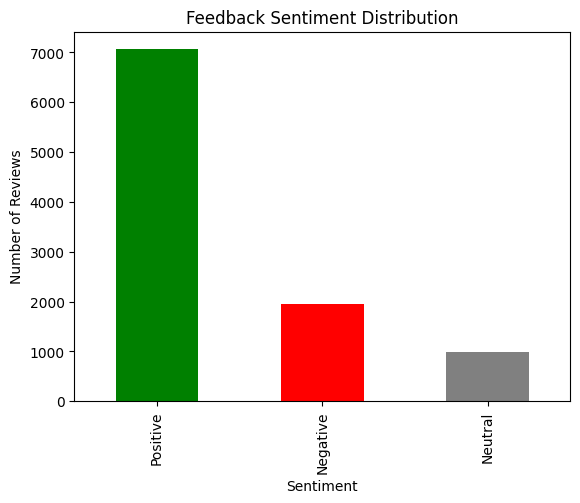

In [9]:
import matplotlib.pyplot as plt

df['feedback_sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Feedback Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

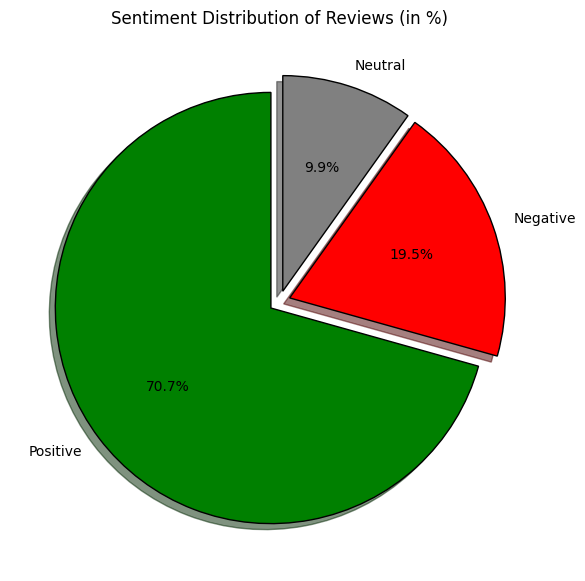

In [10]:
import matplotlib.pyplot as plt

# Step 1: Value counts (with normalization gives percentage)
sentiment_counts = df['feedback_sentiment'].value_counts(normalize=True) * 100

# Step 2: Plot as pie chart
colors = ['green', 'red', 'gray']  # Positive, Negative, Neutral
explode = [0.05] * len(sentiment_counts)  # Slightly explode all slices
wp = {'linewidth': 1, "edgecolor": 'black'}

# Step 3: Plot
plt.figure(figsize=(7, 7))
sentiment_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(sentiment_counts)],
    explode=explode,
    wedgeprops=wp,
    shadow=True
)
plt.title("Sentiment Distribution of Reviews (in %)")
plt.ylabel("")  # Hide y-label
plt.show()

# Word Frequency
Analyse common words

In [11]:
#calculation Term frequency - how freuently words appear again
# Word frequency from cleaned text
tf = df["cleaned_text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
print(tf.head())

       words     tf
0     mother  239.0
1     former  200.0
2  community  209.0
3       upon  244.0
4       vote  214.0


In [12]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T
#"tf" → frequency (how many times each word appears in the dataset)
#tf["tf"] selects just the frequency column.
#“In addition to the usual summary stats, also calculate the 5th, 10th
# , 25th, 50th (median), 75th, 80th, 90th, 95th, and 99th percentiles of word frequencies.”

count    868.000000
mean     227.702765
std       17.582277
min      180.000000
5%       203.000000
10%      208.000000
25%      218.000000
50%      228.000000
75%      237.000000
80%      240.000000
90%      247.000000
95%      252.000000
99%      264.330000
max      489.000000
Name: tf, dtype: float64

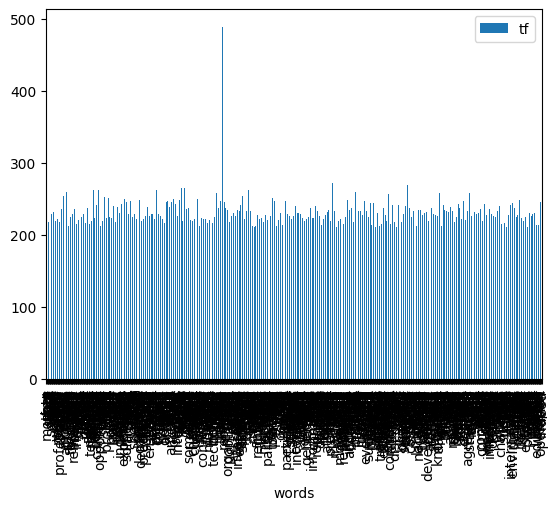

In [13]:
tf[tf["tf"] > 210].plot.bar(x="words", y="tf")
plt.show()

Word Cloud

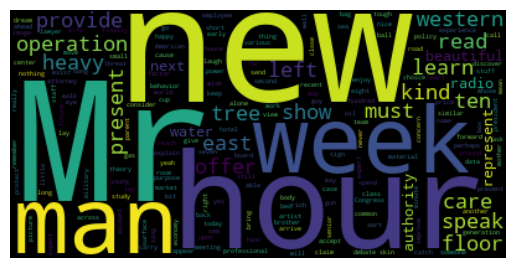

In [14]:
# Wordcloud - combine all reviews in one big string

text = " ".join(i for i in df.review) #combine all reviews in one big string
wordcloud = WordCloud().generate(text) # create workcloud buy giving font size , colour
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

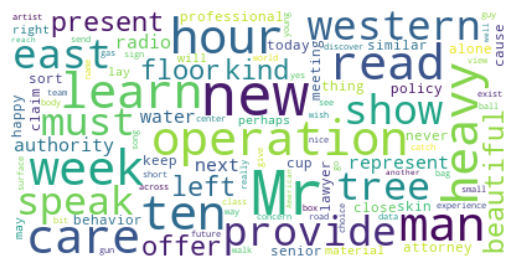

In [15]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

## Sentiment Classification Model

## 1. Convert Text → Numerical Features

a. TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_features=5000, ngram_range=(1,3), stop_words="english")
X = cv.fit_transform(df["cleaned_text"])
y = df["feedback_sentiment"]  # labels (Positive, Negative, Neutral)

print(cv.get_feature_names_out()[:50])  # first 50 features

['ability' 'ability career' 'ability close' 'ability table'
 'ability tough' 'able' 'able instead' 'able reality' 'able wear' 'accept'
 'accept fish' 'accept garden' 'according' 'according able' 'account'
 'account employee' 'account leg' 'act' 'act involve' 'act large'
 'act learn' 'act nearly' 'act officer' 'act official' 'act peace'
 'act positive' 'act staff' 'act suggest' 'act threat' 'act various'
 'act wonder' 'action' 'action best' 'action bring' 'action certainly'
 'action challenge' 'action control' 'action court' 'action enjoy'
 'action establish' 'action expert' 'action fast' 'action feeling'
 'action hotel' 'action key' 'action kind' 'action minute'
 'action mission' 'action paper' 'action policy']


In [29]:
import pandas as pd

df_tfidf = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())
print(df_tfidf.head())

   ability  ability career  ability close  ability table  ability tough  able  \
0      0.0             0.0            0.0            0.0            0.0   0.0   
1      0.0             0.0            0.0            0.0            0.0   0.0   
2      0.0             0.0            0.0            0.0            0.0   0.0   
3      0.0             0.0            0.0            0.0            0.0   0.0   
4      0.0             0.0            0.0            0.0            0.0   0.0   

   able instead  able reality  able wear  accept  ...  young instead  \
0           0.0           0.0        0.0     0.0  ...            0.0   
1           0.0           0.0        0.0     0.0  ...            0.0   
2           0.0           0.0        0.0     0.0  ...            0.0   
3           0.0           0.0        0.0     0.0  ...            0.0   
4           0.0           0.0        0.0     0.0  ...            0.0   

   young local  young maintain  young major  young meet  young partner  \
0     

# 5. Modeling

In [23]:
# Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")  
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7455

Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.27      0.39       390
     Neutral       0.00      0.00      0.00       197
    Positive       0.74      0.98      0.85      1413

    accuracy                           0.75      2000
   macro avg       0.50      0.42      0.41      2000
weighted avg       0.67      0.75      0.68      2000



# Naive Bayes / Linear SVC after applying SMOTE

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Balance training set with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# -----------------------
# 1. Naive Bayes
# -----------------------
nb = MultinomialNB()
nb.fit(X_resampled, y_resampled)

y_pred_nb = nb.predict(X_test)

print("=== Naive Bayes Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# -----------------------
# 2. Linear SVM
# -----------------------
svm = LinearSVC(class_weight="balanced")
svm.fit(X_resampled, y_resampled)

y_pred_svm = svm.predict(X_test)

print("\n=== Linear SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


=== Naive Bayes Results ===
Accuracy: 0.7225
              precision    recall  f1-score   support

    Negative       0.52      0.66      0.58       390
     Neutral       0.35      0.55      0.43       197
    Positive       0.91      0.76      0.83      1413

    accuracy                           0.72      2000
   macro avg       0.59      0.66      0.61      2000
weighted avg       0.78      0.72      0.74      2000


=== Linear SVM Results ===
Accuracy: 0.8065
              precision    recall  f1-score   support

    Negative       0.68      0.74      0.71       390
     Neutral       0.40      0.54      0.46       197
    Positive       0.93      0.86      0.89      1413

    accuracy                           0.81      2000
   macro avg       0.67      0.71      0.69      2000
weighted avg       0.83      0.81      0.82      2000



# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# Train on SMOTE-balanced data
rf.fit(X_resampled, y_resampled)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results ===
Accuracy: 0.846
              precision    recall  f1-score   support

    Negative       0.83      0.63      0.72       390
     Neutral       0.78      0.42      0.55       197
    Positive       0.85      0.96      0.91      1413

    accuracy                           0.85      2000
   macro avg       0.82      0.67      0.72      2000
weighted avg       0.84      0.85      0.83      2000



# Confusion matrix - comparing 

## Naive Bayes / Linear SVM / Random Forest

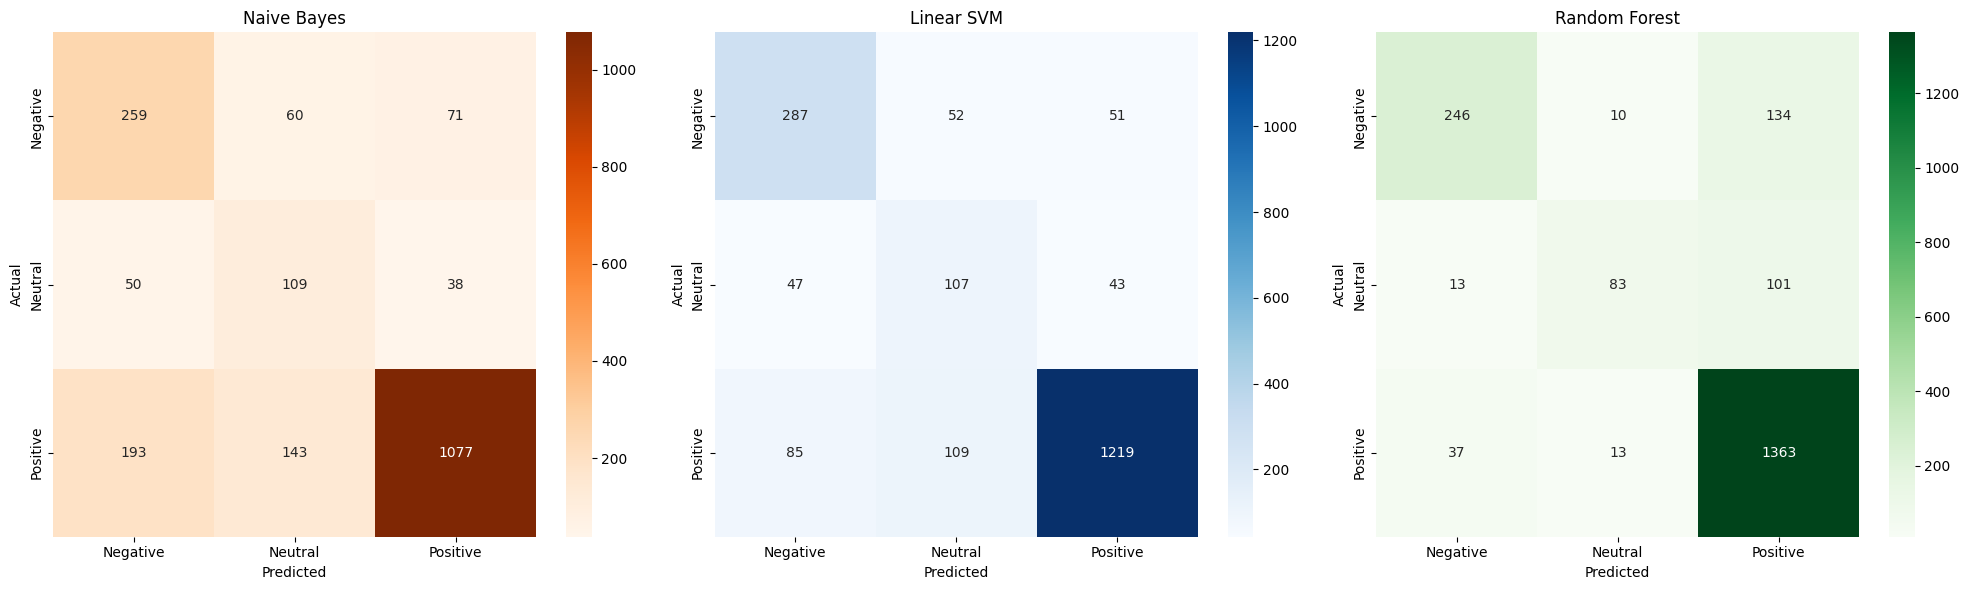

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels for consistent ordering
labels = ["Negative", "Neutral", "Positive"]

# Confusion matrices
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

# Set up side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Naive Bayes
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Oranges", ax=axes[0],
            xticklabels=labels, yticklabels=labels)
axes[0].set_title("Naive Bayes")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Linear SVM
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title("Linear SVM")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=axes[2],
            xticklabels=labels, yticklabels=labels)
axes[2].set_title("Random Forest")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


# Model Evaluation - Random Forest

In [40]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# 1️⃣ Accuracy, Precision, Recall, F1-score
print("=== Random Forest Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# 2️⃣ AUC-ROC (multi-class)
# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=["Negative", "Neutral", "Positive"])

# Get predicted probabilities from Random Forest
y_score_rf = rf.predict_proba(X_test)

# Compute AUC-ROC (macro average)
auc_rf = roc_auc_score(y_test_bin, y_score_rf, average="macro", multi_class="ovr")
print(f"AUC-ROC (macro): {auc_rf:.3f}")

=== Random Forest Evaluation ===
Accuracy: 0.846

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.63      0.72       390
     Neutral       0.78      0.42      0.55       197
    Positive       0.85      0.96      0.91      1413

    accuracy                           0.85      2000
   macro avg       0.82      0.67      0.72      2000
weighted avg       0.84      0.85      0.83      2000

AUC-ROC (macro): 0.905
